# Jupyter Tutorial for Analysis of Radio/Millimeter Data

In [1]:
!pip install astropy

You should consider upgrading via the '/home/ben/miniconda3/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install reproject

You should consider upgrading via the '/home/ben/miniconda3/bin/python -m pip install --upgrade pip' command.


In [3]:
!pip install spectral-cube

You should consider upgrading via the '/home/ben/miniconda3/bin/python -m pip install --upgrade pip' command.


In [4]:
!pip install pyspeckit

You should consider upgrading via the '/home/ben/miniconda3/bin/python -m pip install --upgrade pip' command.


## (1) Importing Python packages you will be using

In [5]:
#Use this window to import packages you will use later
#When you first start working or import a new package, this cell needs to be run before doing anything else.


import numpy as np                          # I use this for maths and sometimes arrays.
                                            # "np" is just an abbreviation since we call this package so often!
import pylab                                # I use this for arrays and plotting
import matplotlib                           # Another plotting package
import matplotlib.gridspec as gridspec      # If there is a task you use a lot, importing it like this 
                                            # keeps you from having to constantly type "matplotlib.gridspec"
                                            # every time you call that task!
import scipy

import astropy.io.fits as fits              # I use this to import FITS images. 
                                            # Astropy should be included in your conda installation
from astropy.wcs import WCS                 # This one helps us add coordinates to images
from astropy import units as u              # This one helps with unit conversion

import pyspeckit as psk                     # I use this to do spectral line fitting
                                            # You probably don't have it installed; 
                                            # to install, type 'pip install pyspeckit' in a terminal window
        
from spectral_cube import SpectralCube      # This is a handy package for working with 3D data cubes

from reproject import reproject_interp      # Reproject is another useful package you should install
from reproject.mosaicking import find_optimal_celestial_wcs 


                                            # Suppress warnings we don't care about:
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

                                            # Super important!! 
                                            # This embeds plots in the Jupyter window 
                                            # (instead of showing them as pop-ups)
%matplotlib inline                             

matplotlib.rc('font', family='sans-serif')  # Set plot fonts
#matplotlib.rc('text', usetex=True)      
matplotlib.rc('text', usetex=False)        # This is a quick fix if you don't have latex on your computer




### Most of our work will be done in "code" type cells, like the previous cell. However, you can use the menu at the top to change the cell type to "markdown" like this one, and add useful comments about your work!

#### You can change font size in these cells by changing the number of hashtags in front of the text. To quickly execute a single cell, you can either click "run" in the menu above, or hit shift + enter 

## (2) Importing and Exporting Data Files

In [6]:
# Lets import our first data file, and take a look at its structure:

path = 'CMZ_3mm_HCN.fits'# This string is not just the name of a file, but its full address.
                                # If, like this file, it is in the same directory as your notebook,
                                # you can specify just the filename. If it lives elsewhere you need
                                # to give a relative (e.g., data/name.fits or ../directory/name.fits)
                                # or absolute (e.g., EACMills/Project/Data/name.fits) path to the file.


                                # The fits images we will work with consist of two main parts:
                                # (1) An array of 2-4 dimensions that holds the value of each image pixel 
                                # (2) A "header" which contains a summary of information associated with this array                
          

image = fits.getdata(path)      # This command reads in the data array part of the fits file, so we can manipulate it 
                                # like any other python array
print(image)     
print(image.data)
print(image[0])
print(image.shape)
print(image[0].shape)
#print(image.header)
#print(image.wcs)

header = fits.getheader(path)   # This command reads in the header, which consists of a series of variables 
                                # and associated values        
        

#print(header)                  #You can use this command to print the entire header if you want to see its contents

    
                                # These commands cover most of the data input (reading from files) that we will do.
                                # There are other commands in python that will perform the same similar functions.
                                # Check out the documentation for astropy.io.fits: https://docs.astropy.org/en/stable/io/fits/
                                # And for spectral cube: https://spectral-cube.readthedocs.io/en/latest/

                                # For completeness, I also include an example of the commands used for data output 
                                # (writing to files). You would use this if you modified the image or header 
                                # in some way, and wanted to make a new file. 

# EXAMPLE:
# Change the units of our image from Jy/beam to mJy/beam. 


mJy_image = image * 1000        # 1 Jy = 1000 mJy so we would multiply our image by 1000
header['BUNIT'] = 'mJy/beam '   # Update the header to reflect these new units
                                # Then save the new image and updated header as a new FITS image:
fits.writeto('CMZ_3mm_HCN_mJy.pbcor.fits',mJy_image,header,overwrite=True) 




[[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 ...

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan n

## (3) Coordinate Systems

In [7]:
# Ultimately, we want to be able to refer to our images using "sky" coordinates:
# Galactic Longitude and Galactic Lattitude, or Galactic coordinates. These are called "World Coordinate Sytems"
# Python tools like WCS make it relatively easy to switch between pixel coordinates and sky coordinates.

w1 = WCS(header)     # This command grabs information from the header, but focuses just on the
                    # part of the header that tells you how pixel coordinates correspond to 
                    # sky coordinates
#NNEED TO MAKE A HEADER FROM NGC????????????       
print(w1)            # This command prints the WCS variable, showing the information it contains



                    # It turns out that there is a slight issue here that we need to address: 
                    # this image has 4 dimensions, but only 2 of those dimensions have information: 
                    # the Galactic Longitude axis (288 pixels long) 
                    # and the Galactic Lattitude axis (288 pixels long)
                    # The other two axes (Frequency and Stokes) have no real length (1 pixel long)
                    # This is firstly because there is no polarization (Stokes) information
                    # Secondly, this is a continuum image so it does not have a frequency axis:
                    # The data have already been averaged over all the observed frequencies.
                    # This means we are basically working with a 2D (288 x 288) image. 

                    # We will thus do two things: first, we will remove the extra axes from the WCS data:

                    
#w1 = w1.dropaxis(3)
w1 = w1.dropaxis(2)

print(w1)
print()
print(w1[0])
#print(wcs_data)    # You can uncomment this to print wcs_data again and confirm that this worked
                    # In addition to editing the WCS, we also want to remove extra axes from the image array.

                    # This command tells us how many dimensions the image data has, and their lengths 
                    # (the number of pixels along each axis):
print("The current image shape is: ", np.shape(image))   
                            
    
image_2D = pylab.squeeze(image) #squeeze gets rid of all axes with length=1.

print("The new image shape is: ", np.shape(image_2D))  # Confirm that squeeze worked.

                    ###################### IMPORTANT: ###########################
                    # If your data are not fundamentally 2D 
                    # (if you are working with a cube) these commands will not
                    # make them 2D! They just get rid of axes without information
                    #############################################################
    

                    # Defining the WCS also lets us take a set of coordinates and change it 
                    # from pixels to sky coordinates and vice versa.
                    # For example, let's figure out the RA and Dec at a position near the center of the image: 
                    # x=144, y=144

RA, Dec = w1.all_pix2world(144,144,0)

print(RA,Dec)       #Notice that these are given in units of degrees



WCS Keywords

Number of WCS axes: 3
CTYPE : 'GLON-SIN'  'GLAT-SIN'  'VOPT'  
CRVAL : 0.541666678728  -0.0416666712776  -154.620038585  
CRPIX : 383.0  83.0  165.5  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : -0.00333333353753  0.00333333353753  1823.24092498  
NAXIS : 765  165  330
WCS Keywords

Number of WCS axes: 2
CTYPE : 'GLON-SIN'  'GLAT-SIN'  
CRVAL : 0.541666678728  -0.0416666712776  
CRPIX : 383.0  83.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.00333333353753  0.00333333353753  
NAXIS : 765  165

SlicedFITSWCS Transformation

This transformation has 1 pixel and 2 world dimensions

Array shape (Numpy order): (765,)

Pixel Dim  Axis Name  Data size  Bounds
        0  None             765  None

World Dim  Axis Name  Physical Type     Units
        0  None       pos.galactic.lon  deg
        1  None       pos.galactic.lat  deg

Correlation between pixel and world axes:

           Pi

## (4) Displaying Images

TypeError: Invalid shape (330, 165, 765) for image data

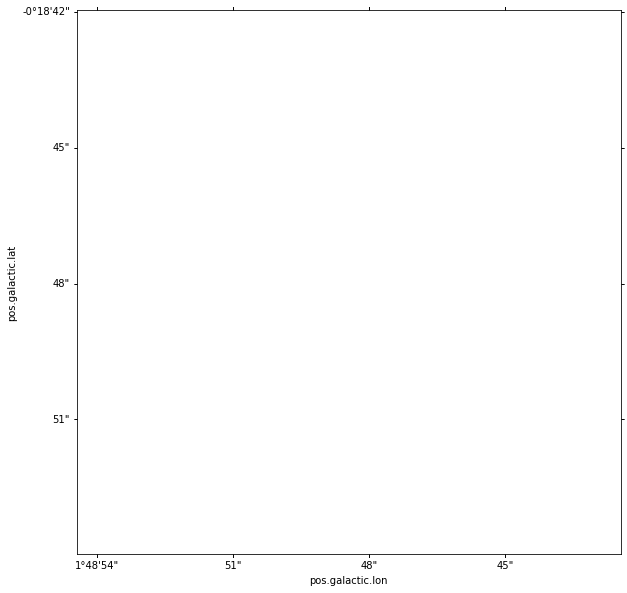

In [8]:
# Let's see what this image actually looks like by making our first figure!

 
fig1 = pylab.figure(1,figsize=(10,10))       # We will make this figure #1 and give it a size of 10x10

                                             # We also want to make sure that our image is plotted with sky coordinates
ax1 = pylab.subplot(projection=w1)            # We do this by specifying a projection (the wcs from the previous cell)
RA = ax1.coords[0]
Dec = ax1.coords[1]

im1 = pylab.imshow(image_2D,cmap='Greys')   # We have a lot of control over how we plot the image.
                                            # We can change the color, range of values, even transparency:
#im1 = pylab.imshow(image_2D,cmap='Greys_r')
#im1 = pylab.imshow(image_2D,cmap='bone',vmin=0,vmax=0.002)
#im1 = pylab.imshow(image_2D,cmap='viridis', vmin=0, alpha=0.5)

                                            # Note that each of these options will plot on top of any 
                                            # previously-displayed image. To display an image as a
                                            # new figure, you need to define a new figure command, 
                                            # with a unique figure number, e.g, fig2 = pylab.figure(2)
                                            
                                            # The options below show other ways to customize this figure 
RA.set_ticks(size=-3)                       # Change the length of the tick marks 
Dec.set_ticks(size=-3)                      # (negative values place ticks inside the bounding box)
pylab.xlabel('Galactic Longitude',fontsize=20,labelpad=1) # Label the x-axis
pylab.ylabel('Galactic Lattitude',fontsize=20,labelpad=0) # Label the y-axis
ax1.tick_params(axis = 'both', which = 'major', labelsize = 15) # Increase the font of the tick labels
pylab.annotate(s='Continuum',fontsize=40,xy=(0.02,0.91),xycoords="axes fraction") # Add a label in the figure
cb=pylab.colorbar(im1,fraction=0.046,pad=0.04) # Define a color bar
cb.set_label(label='Flux Density (Jy / beam)',fontsize=25,rotation=270,labelpad=30) # Add a colorbar label
cb.ax.tick_params(which = 'major', labelsize = 20) # Increase the font size on the colorbar tick labels





## (5) Displaying Different Coordinate Systems

TypeError: Invalid shape (330, 165, 765) for image data

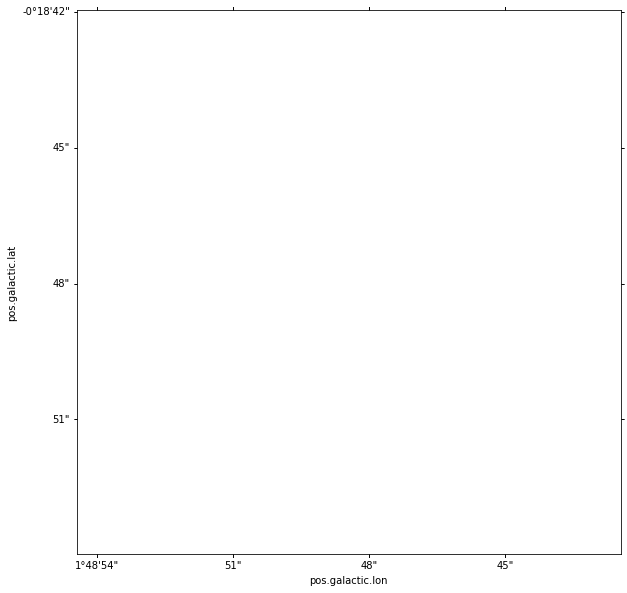

In [12]:
# In general the data we work with was observed in a RA, Dec coordinate system
# However, for observations of sources within our Galaxy, it can be more natural
# to analyze the images in a Galactic coordinate system. 

# Option 1: Overlay another set of coordinate axes

                                                                                    # Repeating previous
fig1 = pylab.figure(1,figsize=(10,10))                                              # commands to 
ax1 = pylab.subplot(projection=w1)                                                  # display the image            
RA = ax1.coords[0]                                                                  # 
Dec = ax1.coords[1]                                                                 # 
                                                                                    #
im1 = pylab.imshow(image_2D,cmap='Greys')                                           #    
RA.set_ticks(size=-3)                                                               #                       
Dec.set_ticks(size=-3)                                                              #                      
pylab.xlabel('Galactic Longitude',fontsize=20,labelpad=1)                              # 
pylab.ylabel('Galactic Lattitude',fontsize=20,labelpad=0)                                  # 
ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)                     # 
pylab.annotate(s='Continuum',fontsize=40,xy=(0.02,0.91),xycoords="axes fraction")   #
cb=pylab.colorbar(im1,fraction=0.041,pad=0.15)                                      # change padding to make room
cb.set_label(label='Flux Density (Jy / beam)',fontsize=25,rotation=270,labelpad=30) #
cb.ax.tick_params(which = 'major', labelsize = 20)                                  #

                                                                                    
overlay = ax1.get_coords_overlay('galactic')                                        # Overlay Galactic 
overlay.grid(color='black', ls='dotted', lw=1)                                      # Coordinate Axes
overlay[0].set_axislabel('Galactic Longitude', fontsize=14)
overlay[1].set_axislabel('Galactic Latitude', fontsize=14)


# Option 2: Transform the entire image to a new coordinate system

wcs_out,shape_out= find_optimal_celestial_wcs([(image_2D,w1)],frame='galactic')     # Use reproject functions
cont,c_footprint = reproject_interp((image_2D,w1),wcs_out,shape_out=shape_out)      # Rotate image

fig2 = pylab.figure(2,figsize=(10,10)) 
ax2 = pylab.subplot(projection=wcs_out)                                                               
lon = ax1.coords[0]                                                                  
lat = ax1.coords[1]

im2 = pylab.imshow(cont,cmap='Greys')
lon.set_ticks(size=-3)                                                                                     
lat.set_ticks(size=-3)                                                                                   
pylab.xlabel('Galactic Longtitude',fontsize=20,labelpad=1)                              
pylab.ylabel('Galactic Latitutude',fontsize=20,labelpad=0)                                  
ax2.tick_params(axis = 'both', which = 'major', labelsize = 15)                      
pylab.annotate(s='Continuum',fontsize=40,xy=(0.02,0.91),xycoords="axes fraction")   
cb=pylab.colorbar(im1,fraction=0.046,pad=0.04)                                      
cb.set_label(label='Flux Density (Jy / beam)',fontsize=25,rotation=270,labelpad=30) 
cb.ax.tick_params(which = 'major', labelsize = 20)                                  


## (6) Moment Maps : Approach 1

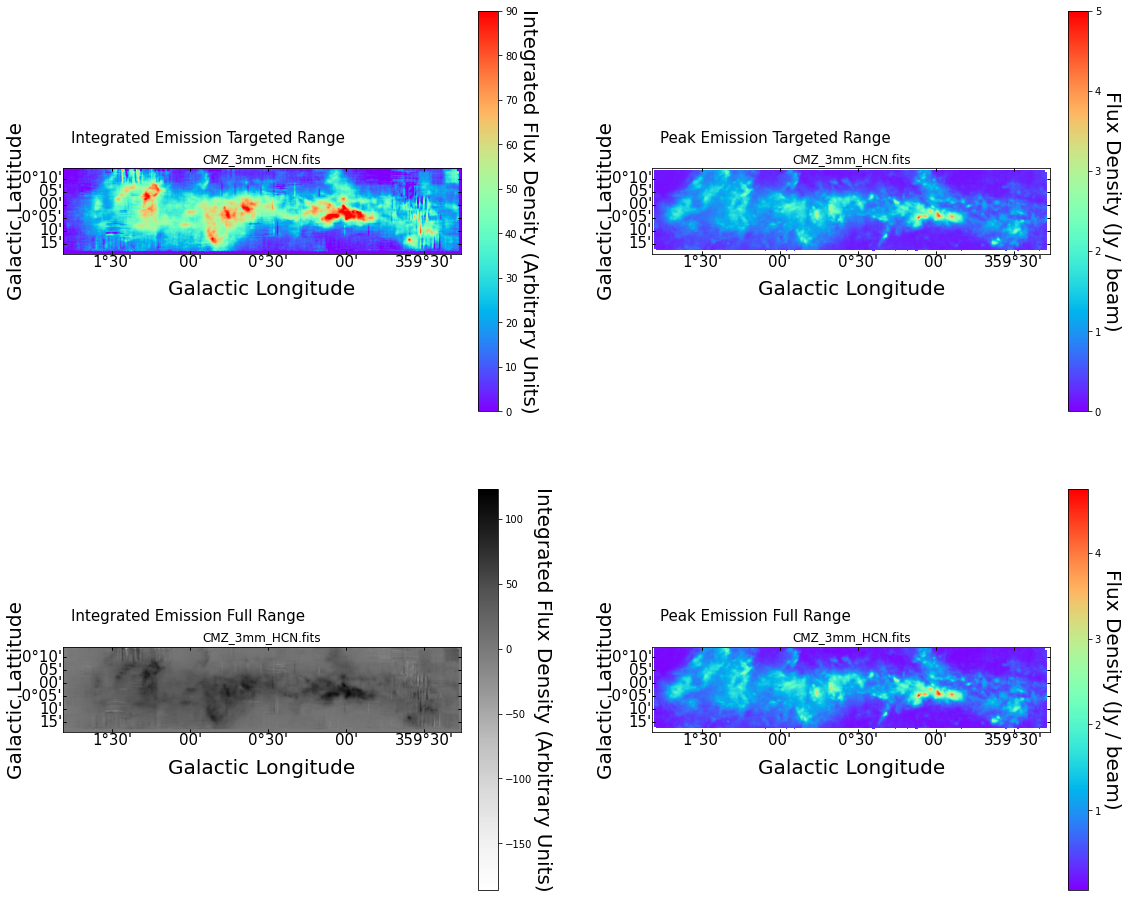

In [13]:
# A lot of the data sets we work with actually have 3 dimensions
# These data sets are referred to as data cubes.
# In addition to the two position axes we saw before, we now also have a frequency axis
# This means our data is a bit like a movie: it consists of a bunch of 2D images, each taken at a different frequency
# We usually refer to the elements in an array along the frequency axis as "channels" 
# (just like the elements in a 2D image array are called pixels)
# We read in these images the same way as the 2D continuum image we just looked at:


new_path = 'CMZ_3mm_HCN.fits'   
cube = pylab.squeeze(fits.getdata(new_path))   # here we are skipping a step and getting rid of the 4th image axis 
                                            # (Stokes) since it still doesn't have data and we don't need it. 
cheader = fits.getheader(new_path)  

#Why not use cheader as the projection?

# Since it is hard to plot a 3D image, there are a few standard approaches we can take. One of them is to make
# something know as a 'moment map'. Here we essentially integrate over the frequency axis. We can take the sum of
# all the pixels (channels) along this axis ("Moment 0") or do some fancier things to instead get the brightest
# value over all the channels in the cube, or even an average velocity for each spatial pixel.


#Let's start with the simplest option and make a frequency-summed or "Moment 0" image of this cube


mom_0 = np.nansum(cube,axis=0)  # notice how the image above looked like a circle, but our array is a 2D rectangle? 
                                # This means that some of the data has been masked by assigning it a value of NAN
                                # We can deal with this, but we have to use special functions (nansum instead of sum)

# Let's also make a map of the maximum value corresponding to each pixel
maxval = np.nanmax(cube,axis=0)#Maybe change the axis?

# Now lets make a fancier figure: a 2-panel, side-by side figure. Check out the online documentation for subplot
# if you have questions about how this works!
fig1 = pylab.figure(1,figsize=(15,15))





ax1 = pylab.subplot(2,2,1,projection=w1) 
RA = ax1.coords[0]                                                                  # 
Dec = ax1.coords[1]
im1 = pylab.imshow(mom_0,cmap='rainbow',vmin=0,vmax=90)
#im1 = pylab.imshow(mom_0,cmap='rainbow')
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3)                                                                                    
pylab.xlabel('Galactic Longitude',fontsize=20,labelpad=1)                               
pylab.ylabel('Galactic Lattitude',fontsize=20,labelpad=0)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im1,fraction=0.046,pad=0.04)                                     
cb.set_label(label='Integrated Flux Density (Arbitrary Units)',fontsize=20,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Integrated Emission Targeted Range',fontsize=15,xy=(0.02,1.3),xycoords="axes fraction")  
#pylab.contour(image_2D,[0.0015,0.002,0.0025,0.003],colors='red')


ax2 = pylab.subplot(2,2,2, projection=w1)
RA = ax2.coords[0]                                                                  # 
Dec = ax2.coords[1]
im2=pylab.imshow(maxval,cmap='rainbow',vmin=0,vmax=5)
#im2 = pylab.imshow(maxval,cmap='rainbow')
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3)                                                                                    
pylab.xlabel('Galactic Longitude',fontsize=20,labelpad=1)                               
pylab.ylabel('Galactic Lattitude',fontsize=20,labelpad=0) 
ax2.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im2,fraction=0.046,pad=0.04)                                      
cb.set_label(label='Flux Density (Jy / beam)',fontsize=20,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)  
pylab.annotate(s='Peak Emission Targeted Range',fontsize=15,xy=(0.02,1.3),xycoords="axes fraction")  
#pylab.contour(image_2D,[0.0015,0.002,0.0025,0.003],colors='red')
#pylab.annotate(s='Continuum Contours',fontsize=15,xy=(0.45,0.02),xycoords="axes fraction",color='red') 
pylab.tight_layout(w_pad=10)


ax3 = pylab.subplot(2,2,3,projection=w1) 
RA = ax3.coords[0]                                                                  # 
Dec = ax3.coords[1]
im3 = pylab.imshow(mom_0,cmap='Greys')
#im1 = pylab.imshow(mom_0,cmap='rainbow')
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3)                                                                                    
pylab.xlabel('Galactic Longitude',fontsize=20,labelpad=1)                               
pylab.ylabel('Galactic Lattitude',fontsize=20,labelpad=0)
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im3,fraction=0.046,pad=0.04)                                     
cb.set_label(label='Integrated Flux Density (Arbitrary Units)',fontsize=20,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Integrated Emission Full Range',fontsize=15,xy=(0.02,1.3),xycoords="axes fraction")  
#pylab.contour(image_2D,[0.0015,0.002,0.0025,0.003],colors='red')

ax4 = pylab.subplot(2,2,4, projection=w1)
RA = ax4.coords[0]                                                                  # 
Dec = ax4.coords[1]
im4=pylab.imshow(maxval,cmap='rainbow')
#im2 = pylab.imshow(maxval,cmap='rainbow')
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3)                                                                                    
pylab.xlabel('Galactic Longitude',fontsize=20,labelpad=1)                               
pylab.ylabel('Galactic Lattitude',fontsize=20,labelpad=0) 
ax4.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im4,fraction=0.046,pad=0.04)                                      
cb.set_label(label='Flux Density (Jy / beam)',fontsize=20,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)  
pylab.annotate(s='Peak Emission Full Range',fontsize=15,xy=(0.02,1.3),xycoords="axes fraction")  
#pylab.contour(image_2D,[0.0015,0.002,0.0025,0.003],colors='red')
#pylab.annotate(s='Continuum Contours',fontsize=15,xy=(0.45,0.02),xycoords="axes fraction",color='red') 
pylab.tight_layout(w_pad=10)


ax1.set_title("CMZ_3mm_HCN.fits")
ax2.set_title("CMZ_3mm_HCN.fits")
ax3.set_title("CMZ_3mm_HCN.fits")
ax4.set_title("CMZ_3mm_HCN.fits")




fig1.savefig("CMZ_3mm_HCN_Integrated.jpeg")
#pylab.savefig('12CO_moment0.pdf') #Uncomment this to save your current figure as a PDF in this directory

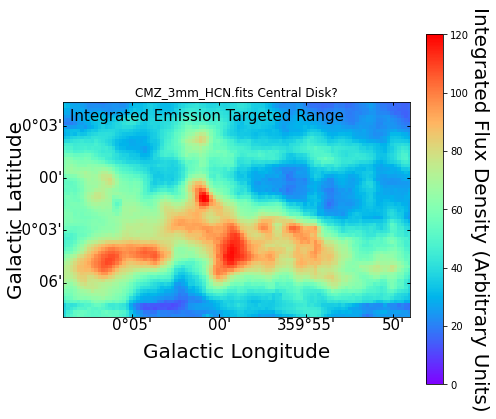

In [14]:
#Make a pic of the accretion disk just for fun

new_path = 'CMZ_3mm_HCN.fits'   
cube = pylab.squeeze(fits.getdata(new_path))   # here we are skipping a step and getting rid of the 4th image axis 
                                            # (Stokes) since it still doesn't have data and we don't need it. 
cheader = fits.getheader(new_path)  

#Why not use cheader as the projection?

# Since it is hard to plot a 3D image, there are a few standard approaches we can take. One of them is to make
# something know as a 'moment map'. Here we essentially integrate over the frequency axis. We can take the sum of
# all the pixels (channels) along this axis ("Moment 0") or do some fancier things to instead get the brightest
# value over all the channels in the cube, or even an average velocity for each spatial pixel.


#Let's start with the simplest option and make a frequency-summed or "Moment 0" image of this cube


mom_0 = np.nansum(cube,axis=0)  # notice how the image above looked like a circle, but our array is a 2D rectangle? 
                                # This means that some of the data has been masked by assigning it a value of NAN
                                # We can deal with this, but we have to use special functions (nansum instead of sum)



# Now lets make a fancier figure: a 2-panel, side-by side figure. Check out the online documentation for subplot
# if you have questions about how this works!
fig1 = pylab.figure(1,figsize=(15,15))

cen_dec1=int(len(mom_0)/3)
cen_dec2=int(len(mom_0)/1.4)
cen_ra1=500
cen_ra2=600


ax1 = pylab.subplot(2,2,1,projection=w1[cen_dec1:cen_dec2,500:cen_ra2]) 
RA = ax1.coords[0]                                                                  # 
Dec = ax1.coords[1]
im1 = pylab.imshow(mom_0[cen_dec1:cen_dec2,cen_ra1:cen_ra2],cmap='rainbow',vmin=0,vmax=120)
#im1 = pylab.imshow(mom_0,cmap='rainbow')
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3)                                                                                    
pylab.xlabel('Galactic Longitude',fontsize=20,labelpad=1)                               
pylab.ylabel('Galactic Lattitude',fontsize=20,labelpad=0)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im1,fraction=0.046,pad=0.04)                                     
cb.set_label(label='Integrated Flux Density (Arbitrary Units)',fontsize=20,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Integrated Emission Targeted Range',fontsize=15,xy=(0.02,0.91),xycoords="axes fraction")  


ax1.set_title("CMZ_3mm_HCN.fits Central Disk?")

fig1.savefig("CMZ_3mm_HCN_Central_Disk.jpeg")

## (7) Moment Maps: Approach 2 and Image Masking

SpectralCube with shape=(55, 165, 765) and unit=K:
 n_x:    765  type_x: GLON-SIN  unit_x: deg    range:     1.815115 deg:  359.268218 deg
 n_y:    165  type_y: GLAT-SIN  unit_y: deg    range:    -0.314991 deg:    0.231678 deg
 n_s:     55  type_s: VRAD-W2F  unit_s: km / s  range:      -97.730 km / s:     197.537 km / s


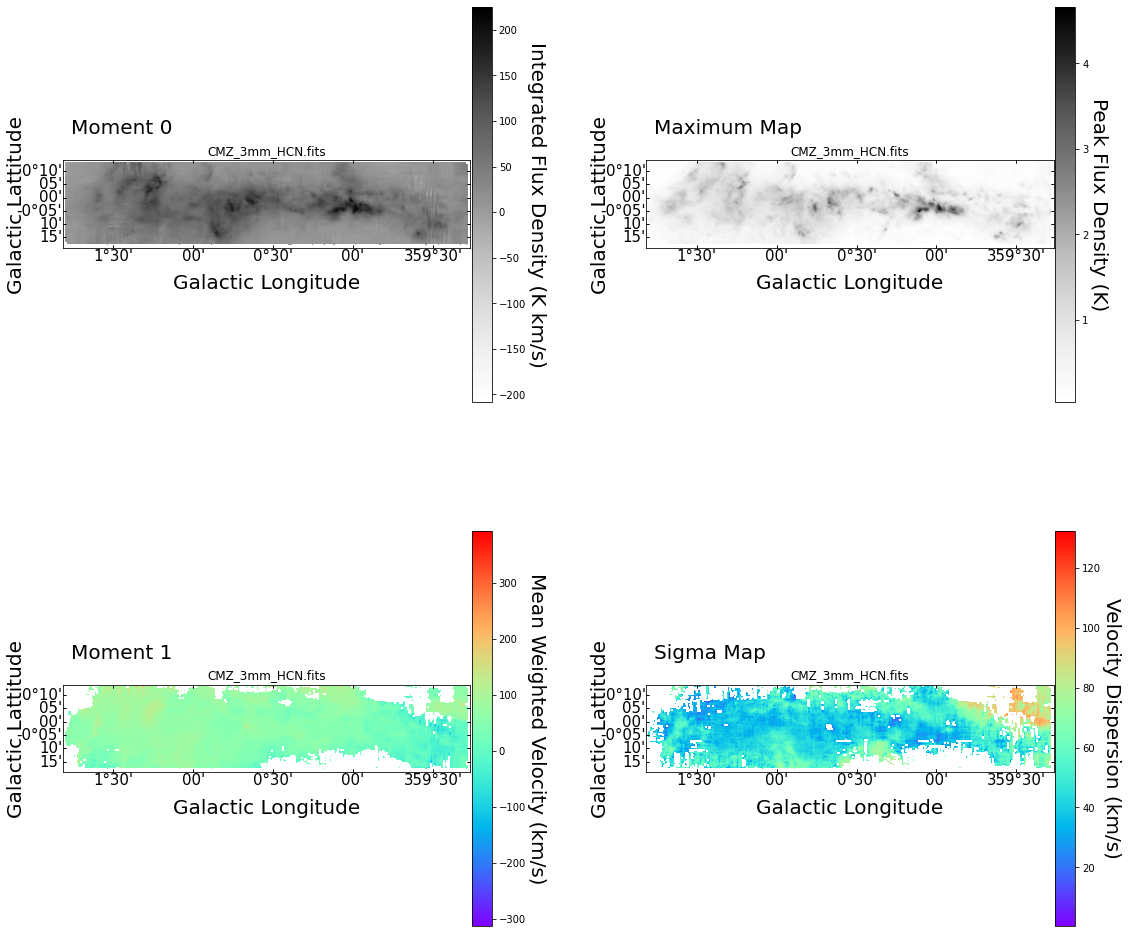

In [15]:
# To make higher-order moments involving the frequency axis, 
# it is easier to use a package that has pre-written functions for this purpose

                                            # SpectralCube gives us another way to load our 3D data into python
sc = SpectralCube.read(new_path)            # Note that s_c is a more complicated structure than an array
                                            # It stores information on the axes and their associated units
                                            # A handy thing it can do is to change these units to better match
                                            # our needs!
        
                                            # Alternatively, you can create a spectral cube object from 
                                            # data you have already imported

#cube = pylab.squeeze(fits.getdata(new_path))
#w = WCS(newpath)
#sc = SpectralCube(data=cube,wcs=w)
        
sc_kms = sc.with_spectral_unit(u.km/u.s,velocity_convention="radio") # change from frequency to velocity
sc_slab = sc_kms.spectral_slab(-100. *u.km / u.s, 200. *u.km / u.s)  # Extract a subset of the velocities
sc_slab.allow_huge_operations=True

                                            # OPTIONAL:
sc_bin = sc_slab.downsample_axis(3,axis=0)  # the spectral axis is still *really* long, so we bin it by a factor of 3 


sc_K_kms = sc_bin.to(u.K)                   # Change intensity unit from Jy/beam to K
                                            


print(sc_K_kms)


moment_0  = sc_K_kms.moment(order=0,how='slice')            # Calculate the Moment 0 map 
max_map   = sc_K_kms.apply_numpy_function(np.nanmax,axis=0) # Calculate the Maximum map 
moment_1  = sc_K_kms.moment(order=1,how='slice')            # Calculate the Moment 1 map 
sigma_map = sc_K_kms.linewidth_sigma(how='slice')           # Calculate the velocity dispersion map 

#started at 100?
badpix = pylab.where(moment_0.hdu.data<10)                 # Get ready to mask the data based on moment map
moment_1.hdu.data[badpix] = np.nan                          # Mask the moment 1 map
sigma_map.hdu.data[badpix] = np.nan                         # Mask the velocity dispersion map


fig1 = pylab.figure(1,figsize=(15,15))

ax1 = pylab.subplot(2,2,1,projection=moment_0.wcs) 
im1 = pylab.imshow(moment_0.hdu.data,cmap='Greys')
RA = ax1.coords[0]                                                                  
Dec = ax1.coords[1]
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3)                                                                                    
pylab.xlabel('Galactic Longitude',fontsize=20,labelpad=1)                               
pylab.ylabel('Galactic Lattitude',fontsize=20,labelpad=0)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im1,fraction=0.046,pad=0.004)                                      
cb.set_label(label='Integrated Flux Density (K km/s)',fontsize=20,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Moment 0',fontsize=20,xy=(0.02,1.3),xycoords="axes fraction")  
#pylab.contour(image_2D,[0.0015,0.002,0.0025,0.003],colors='red')

ax2 = pylab.subplot(2,2,2,projection=moment_0.wcs) 
im2 = pylab.imshow(max_map.data,cmap='Greys')
RA = ax2.coords[0]                                                                  
Dec = ax2.coords[1]
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3)                                                                                    
pylab.xlabel('Galactic Longitude',fontsize=20,labelpad=1)                               
pylab.ylabel('Galactic Lattitude',fontsize=20,labelpad=0)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im2,fraction=0.046,pad=0.004)                                      
cb.set_label(label='Peak Flux Density (K)',fontsize=20,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Maximum Map',fontsize=20,xy=(0.02,1.3),xycoords="axes fraction")

ax3 = pylab.subplot(2,2,3,projection=moment_0.wcs) 
im3 = pylab.imshow(moment_1.hdu.data,cmap='rainbow')
RA = ax3.coords[0]                                                                  
Dec = ax3.coords[1]
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3)                                                                                    
pylab.xlabel('Galactic Longitude',fontsize=20,labelpad=1)                               
pylab.ylabel('Galactic Lattitude',fontsize=20,labelpad=0)
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im3,fraction=0.046,pad=0.004)                                      
cb.set_label(label='Mean Weighted Velocity (km/s)',fontsize=20,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Moment 1',fontsize=20,xy=(0.02,1.3),xycoords="axes fraction")

ax4 = pylab.subplot(2,2,4,projection=moment_0.wcs) 
im4 = pylab.imshow(sigma_map.hdu.data,cmap='rainbow')
RA = ax4.coords[0]                                                                  
Dec = ax4.coords[1]
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3)                                                                                    
pylab.xlabel('Galactic Longitude',fontsize=20,labelpad=1)                               
pylab.ylabel('Galactic Lattitude',fontsize=20,labelpad=0)
ax4.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im4,fraction=0.046,pad=0.004)                                      
cb.set_label(label='Velocity Dispersion (km/s)',fontsize=20,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Sigma Map',fontsize=20,xy=(0.02,1.3),xycoords="axes fraction");

pylab.tight_layout(w_pad=10)


ax1.set_title("CMZ_3mm_HCN.fits")
ax2.set_title("CMZ_3mm_HCN.fits")
ax3.set_title("CMZ_3mm_HCN.fits")
ax4.set_title("CMZ_3mm_HCN.fits")


fig1.savefig("CMZ_3mm_HCN_Images.jpeg")

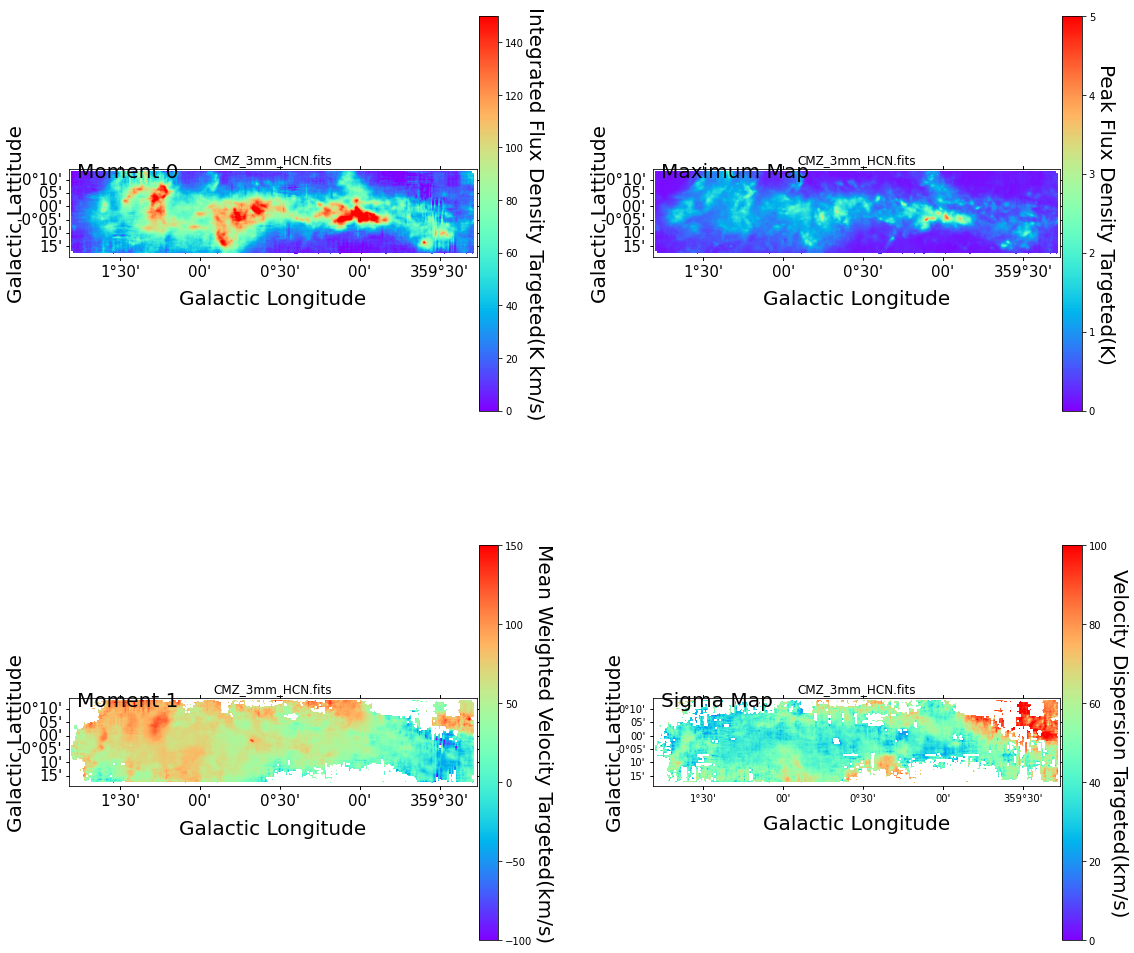

In [16]:
#Targeted maps

fig1T = pylab.figure(1,figsize=(15,15))

ax1T = pylab.subplot(2,2,1,projection=moment_0.wcs) 
im1T = pylab.imshow(moment_0.hdu.data,cmap='rainbow',vmin=0,vmax=150)
RA = ax1.coords[0]                                                                  
Dec = ax1.coords[1]
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3)                                                                                    
pylab.xlabel('Galactic Longitude',fontsize=20,labelpad=1)                               
pylab.ylabel('Galactic Lattitude',fontsize=20,labelpad=0)
ax1T.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im1T,fraction=0.046,pad=0.004)                                      
cb.set_label(label='Integrated Flux Density Targeted(K km/s)',fontsize=20,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Moment 0',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction")  
#pylab.contour(image_2D,[0.0015,0.002,0.0025,0.003],colors='red')

ax2T = pylab.subplot(2,2,2,projection=moment_0.wcs) 
im2T = pylab.imshow(max_map.data,cmap='rainbow',vmin=0,vmax=5)
RA = ax2.coords[0]                                                                  
Dec = ax2.coords[1]
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3)                                                                                    
pylab.xlabel('Galactic Longitude',fontsize=20,labelpad=1)                               
pylab.ylabel('Galactic Lattitude',fontsize=20,labelpad=0)
ax2T.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im2T,fraction=0.046,pad=0.004)                                      
cb.set_label(label='Peak Flux Density Targeted(K)',fontsize=20,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Maximum Map',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction")

ax3T = pylab.subplot(2,2,3,projection=moment_0.wcs) 
im3T = pylab.imshow(moment_1.hdu.data,cmap='rainbow',vmin=-100,vmax=150)
RA = ax3.coords[0]                                                                  
Dec = ax3.coords[1]
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3)                                                                                    
pylab.xlabel('Galactic Longitude',fontsize=20,labelpad=1)                               
pylab.ylabel('Galactic Lattitude',fontsize=20,labelpad=0)
ax3T.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im3T,fraction=0.046,pad=0.004)                                      
cb.set_label(label='Mean Weighted Velocity Targeted(km/s)',fontsize=20,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Moment 1',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction")

ax4T = pylab.subplot(2,2,4,projection=moment_0.wcs) 
im4T = pylab.imshow(sigma_map.hdu.data,cmap='rainbow',vmin=0,vmax=100)
RA = ax4.coords[0]                                                                  
Dec = ax4.coords[1]
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3)                                                                                    
pylab.xlabel('Galactic Longitude',fontsize=20,labelpad=1)                               
pylab.ylabel('Galactic Lattitude',fontsize=20,labelpad=0)
ax4.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im4T,fraction=0.046,pad=0.004)                                      
cb.set_label(label='Velocity Dispersion Targeted(km/s)',fontsize=20,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Sigma Map',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction");

pylab.tight_layout(w_pad=10)

ax1T.set_title("CMZ_3mm_HCN.fits")
ax2T.set_title("CMZ_3mm_HCN.fits")
ax3T.set_title("CMZ_3mm_HCN.fits")
ax4T.set_title("CMZ_3mm_HCN.fits")

fig1T.savefig("CMZ_3mm_HCN_Images_T.jpeg")

## (8) 2D Reprojection and Image Ratios

SpectralCube with shape=(330, 165, 765) and unit=K:
 n_x:    765  type_x: GLON-SIN  unit_x: deg    range:     1.815115 deg:  359.268218 deg
 n_y:    165  type_y: GLAT-SIN  unit_y: deg    range:    -0.314991 deg:    0.231678 deg
 n_s:    330  type_s: VOPT      unit_s: m / s  range:  -300077.752 m / s:  299768.512 m / s
SpectralCube with shape=(321, 165, 765) and unit=K:
 n_x:    765  type_x: GLON-SIN  unit_x: deg    range:     1.815115 deg:  359.268218 deg
 n_y:    165  type_y: GLAT-SIN  unit_y: deg    range:    -0.314991 deg:    0.231678 deg
 n_s:    321  type_s: VOPT      unit_s: m / s  range:  -300103.070 m / s:  298820.114 m / s


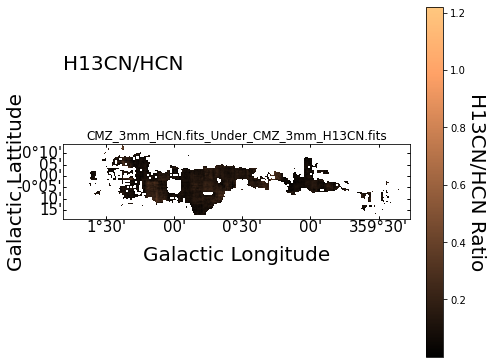

In [18]:
# A useful exercise is to compare data from different species. First, we want to compare 13CO and 12CO 
# (and eventually C18O, and C17O)
# Here, we demonstrate a method to match shapes of 2D images (like moment maps) so we can calculate ratios.
        
#The old names of variables are kept for now, but this can be data other than sc12
sc13 = SpectralCube.read('CMZ_3mm_HCN.fits')    
print(sc13)                                              

sc12 = SpectralCube.read('CMZ_3mm_H13CN.fits')    # Comparing to the 13 CO,
print(sc12)                                              # here we immediately see this image is a different shape.
                                                        # In order to compare the two, we have to make them the same.

    


sc13_kms = sc13.with_spectral_unit(u.km/u.s,velocity_convention="radio")
sc13_kms.allow_huge_operations=True
sc13_K_kms = sc13_kms.to(u.K)
sc12_kms = sc12.with_spectral_unit(u.km/u.s,velocity_convention="radio")
sc12_kms.allow_huge_operations=True
sc12_K_kms = sc12_kms.to(u.K)

sc13_moment0  = sc13_K_kms.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
sc12_moment0  = sc12_K_kms.moment(order=0,how='slice')    # Calculate the second Moment 0 map 


sc13_moment0_reproject, footprint = reproject_interp(sc13_moment0.hdu,sc12_moment0.header)

                                                        # Now that images are same size, compute ratio of moment maps
ratio_12CO_13CO = sc12_moment0.hdu.data/sc13_moment0_reproject

badpix = pylab.where(sc13_moment0_reproject<50) # Identify emission below a threshold to mask
badpix2 = pylab.where(sc12_moment0.hdu.data<0)           # Mask 12CO absorption
ratio_12CO_13CO[badpix] = np.nan                        # Mask the ratio map
ratio_12CO_13CO[badpix2] = np.nan

fig1 = pylab.figure(1,figsize=(15,15))

ax1 = pylab.subplot(2,2,1,projection=sc12_moment0.wcs) 
im1 = pylab.imshow(ratio_12CO_13CO,cmap='copper')
RA = ax1.coords[0]                                                                  
Dec = ax1.coords[1]
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3)                                                                                    
pylab.xlabel('Galactic Longitude',fontsize=20,labelpad=1)                               
pylab.ylabel('Galactic Lattitude',fontsize=20,labelpad=0)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im1,fraction=0.046,pad=0.04)                                      
cb.set_label(label='H13CN/HCN Ratio',fontsize=20,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='H13CN/HCN',fontsize=20,xy=(0,2),xycoords="axes fraction");  
    
    
ax1.set_title("CMZ_3mm_HCN.fits_Under_CMZ_3mm_H13CN.fits")


fig1.savefig("CMZ_3mm_HCN_Under_CMZ_3mm_H13CN_Ratio.jpeg")

## (9) Channel Maps and P-V Plots

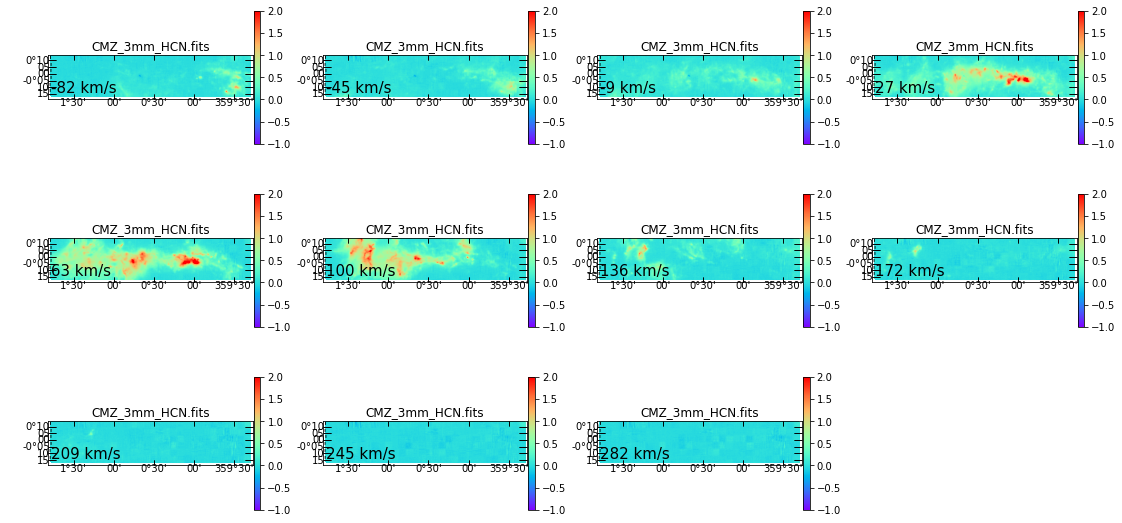

In [21]:
# In addition to moment maps, there are several other ways to extract 2D information from a data cube.
# The most common are channel maps and PV (position-velocity) diagrams.

# Example 1: Channel Maps (using the 12CO read in from the previous cell)

sc13_slab = sc13_K_kms.spectral_slab(-100. *u.km / u.s, 500. *u.km / u.s)  # Extract a subset of the velocities
sc13_bin = sc13_slab.downsample_axis(20,axis=0) # Here we use downsampling to bin (average)the data 
                                                # into coarse bins (broad channels) with width ~ 11 km/s    

vel, dec, ra = sc13_bin.world[:,0,0]           # For plotting purposes, I want to know the average velocity
                                                # for each of these new averaged channels

fig1 = pylab.figure(1,figsize=(15,20))

                                            
for i in np.arange(0,len(sc13_bin.hdu.data)):                       # Now we loop through each slice (averaged channels) 
    ax = pylab.subplot(8,4,i+1,projection=sc13_moment0.wcs) # We plot them in a grid
    im = pylab.imshow(sc13_bin.hdu.data[i],cmap='rainbow',vmin=-1,vmax=2)
    ax.set_title("CMZ_3mm_HCN.fits")
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-5)                                                                                      
    Dec.set_ticks(size=-8)  
    pylab.text(10,25,s="%i km/s"%(vel.value[i]),fontsize=15) # Print the velocity of each averaged channel
    cb=pylab.colorbar(im,fraction=0.046,pad=0.004) #Color is slab intensity?
    if i==28:
        pylab.xlabel("Galactic Longitude")
        pylab.ylabel("Galactic Lattitude")
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
        
pylab.tight_layout(w_pad=4,h_pad=4)


fig1.savefig("CMZ_3mm_HCN_CM_F.jpeg")

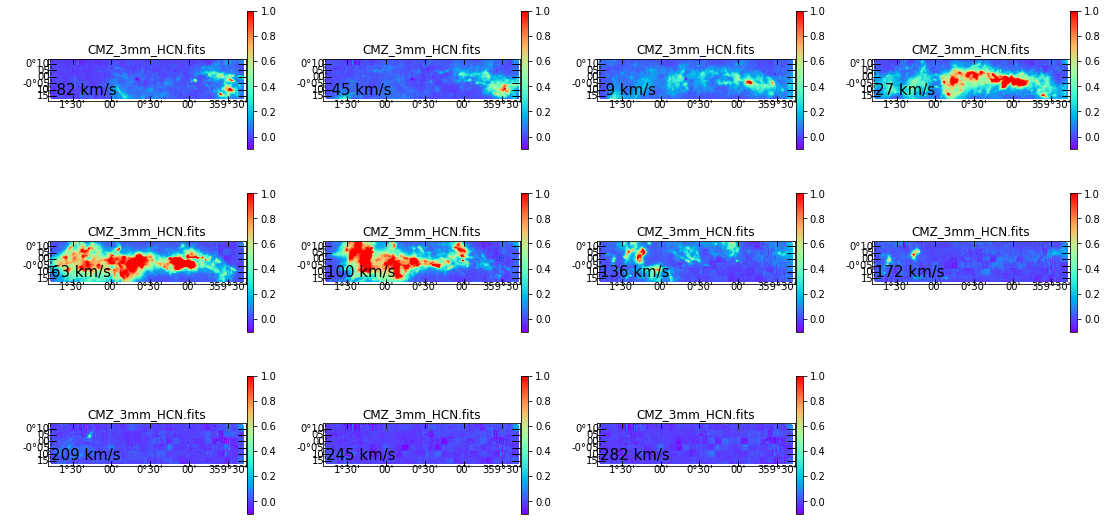

In [22]:
#Targeted
sc13_slab = sc13_K_kms.spectral_slab(-100. *u.km / u.s, 500. *u.km / u.s)  # Extract a subset of the velocities
sc13_bin = sc13_slab.downsample_axis(20,axis=0) # Here we use downsampling to bin (average)the data 
                                                # into coarse bins (broad channels) with width ~ 11 km/s    

vel, dec, ra = sc13_bin.world[:,0,0]           # For plotting purposes, I want to know the average velocity
                                                # for each of these new averaged channels

fig1 = pylab.figure(1,figsize=(15,20))

                                            
for i in np.arange(0,len(sc13_bin.hdu.data)):                       # Now we loop through each slice (averaged channels) 
    ax = pylab.subplot(8,4,i+1,projection=sc13_moment0.wcs) # We plot them in a grid
    im = pylab.imshow(sc13_bin.hdu.data[i],cmap='rainbow',vmin=-.1,vmax=1)
    ax.set_title("CMZ_3mm_HCN.fits")
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-5)                                                                                      
    Dec.set_ticks(size=-8)  
    pylab.text(10,25,s="%i km/s"%(vel.value[i]),fontsize=15) # Print the velocity of each averaged channel
    cb=pylab.colorbar(im,fraction=0.046,pad=0.004) #Color is slab intensity?
    if i==28:
        pylab.xlabel("Galactic Longitude")
        pylab.ylabel("Galactic Lattitude")
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
        
pylab.tight_layout(w_pad=4,h_pad=4)

fig1.savefig("CMZ_3mm_HCN_CM_T.jpeg")


255.0


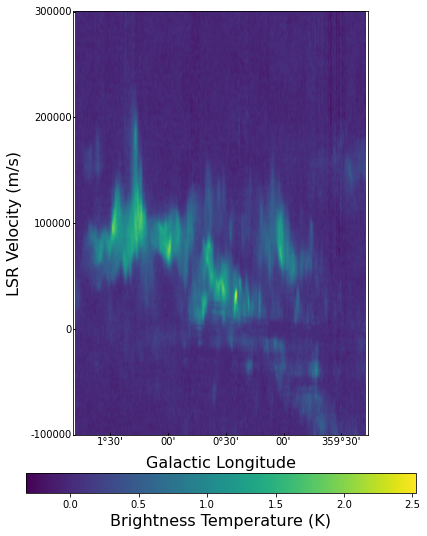

In [23]:
# Example 2: PV Diagrams
# Here we try to examine the velocity structure of an image by making a 2D plot of position vs. velocity
# We reduce the data to 2D by either averaging along one of the position axes (RA or Dec)
# or in this case, just choosing a single "slice" from the Galactic Lattitude axis

Dec_slice = int(len(sc13_slab[0][0])/7)                            # Pick a pixel along the Galactic Lattitude dimension to slice along
print(len(sc13_slab[0][0])/3)
                                    
fig = pylab.figure(1,figsize=(7, 10))         # Initiate a figure and axis object with WCS projection information

                                            # Here we have specified to plot the longitude along the x axis
                                            # We also plot only the Galactic Lattitude slice we have chosen, 
                                            # and plot the velocity along the y axis
ax = fig.add_subplot(111, projection=sc13_slab.wcs, slices=('x', Dec_slice, 'y'))
RA = ax.coords[0]
Dec = ax.coords[1]
velo = ax.coords[2]

im = ax.imshow(sc13_slab[:,Dec_slice, :].data)  # Display the image slice 
ax.set_aspect(aspect=5)
#print(sc13_slab)
#print(sc13_slab[0])

'''
for m in range(len(sc13_slab)-1):
    num_values=0
    for i in range(len(sc13_slab[m])-1):
        if(np.nansum(sc13_slab[m][i].data)!=0):
            num_values+=1
    print(num_values,m)
'''
            #print(np.nansum(sc13_slab[m][i]))
            #print(i,m)
            
            
#print(sc13_slab.shape)
#print(sc13_slab.header)
                                            # Add axes labels
ax.set_ylabel("LSR Velocity (m/s)", fontsize=16)
ax.set_xlabel("Galactic Longitude", fontsize=16)
velo.set_ticks(size=-2)                                                                                      
RA.set_ticks(size=-2)
                            
Dec.set_ticks_visible(False)                # Don't show a "Galactic Lattitude" axis because we have eliminated it
Dec.set_ticklabel_visible(False) 

                                            # Do add a colorbar
cbar = pylab.colorbar(im, pad=.07, orientation='horizontal')
cbar.set_label('Brightness Temperature (K)', size=16)




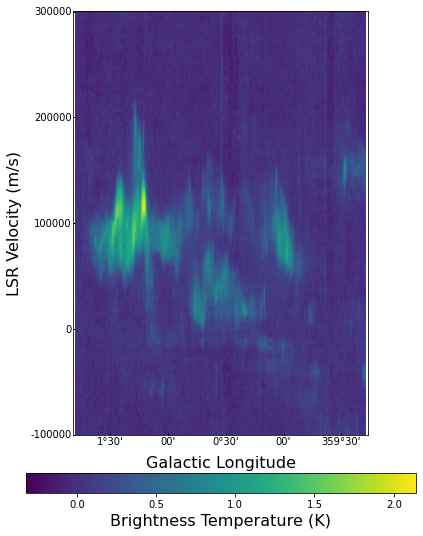

In [26]:
fig = pylab.figure(1,figsize=(7, 10))         # Initiate a figure and axis object with WCS projection information

                                            # Here we have specified to plot the longitude along the x axis
                                            # We also plot only the Galactic Lattitude slice we have chosen, 
                                            # and plot the velocity along the y axis
ax = fig.add_subplot(111, projection=sc13_slab.wcs, slices=('x', Dec_slice, 'y'))
RA = ax.coords[0]
Dec = ax.coords[1]
velo = ax.coords[2]

im = ax.imshow(sc13_slab[:,Dec_slice+10, :].data)  # Display the image slice 
ax.set_aspect(aspect=5)
#print(sc13_slab)
#print(sc13_slab[0])

'''
for m in range(len(sc13_slab)-1):
    num_values=0
    for i in range(len(sc13_slab[m])-1):
        if(np.nansum(sc13_slab[m][i].data)!=0):
            num_values+=1
    print(num_values,m)
'''
            #print(np.nansum(sc13_slab[m][i]))
            #print(i,m)
            
            
#print(sc13_slab.shape)
#print(sc13_slab.header)
                                            # Add axes labels
ax.set_ylabel("LSR Velocity (m/s)", fontsize=16)
ax.set_xlabel("Galactic Longitude", fontsize=16)
velo.set_ticks(size=-2)                                                                                      
RA.set_ticks(size=-2)
                            
Dec.set_ticks_visible(False)                # Don't show a "Galactic Lattitude" axis because we have eliminated it
Dec.set_ticklabel_visible(False) 

                                            # Do add a colorbar
cbar = pylab.colorbar(im, pad=.07, orientation='horizontal')
cbar.set_label('Brightness Temperature (K)', size=16)


fig.savefig("CMZ_3mm_HCN_PV_Best.jpeg")

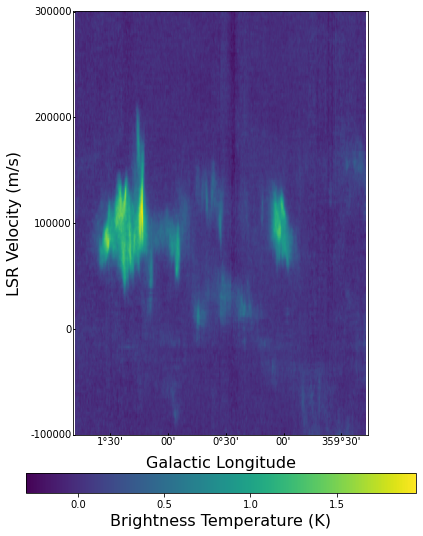

In [25]:
fig = pylab.figure(1,figsize=(7, 10))         # Initiate a figure and axis object with WCS projection information

                                            # Here we have specified to plot the longitude along the x axis
                                            # We also plot only the Galactic Lattitude slice we have chosen, 
                                            # and plot the velocity along the y axis
ax = fig.add_subplot(111, projection=sc13_slab.wcs, slices=('x', Dec_slice, 'y'))
RA = ax.coords[0]
Dec = ax.coords[1]
velo = ax.coords[2]

im = ax.imshow(sc13_slab[:,Dec_slice+20, :].data)  # Display the image slice 
ax.set_aspect(aspect=5)
#print(sc13_slab)
#print(sc13_slab[0])

'''
for m in range(len(sc13_slab)-1):
    num_values=0
    for i in range(len(sc13_slab[m])-1):
        if(np.nansum(sc13_slab[m][i].data)!=0):
            num_values+=1
    print(num_values,m)
'''
            #print(np.nansum(sc13_slab[m][i]))
            #print(i,m)
            
            
#print(sc13_slab.shape)
#print(sc13_slab.header)
                                            # Add axes labels
ax.set_ylabel("LSR Velocity (m/s)", fontsize=16)
ax.set_xlabel("Galactic Longitude", fontsize=16)
velo.set_ticks(size=-2)                                                                                      
RA.set_ticks(size=-2)
                            
Dec.set_ticks_visible(False)                # Don't show a "Galactic Lattitude" axis because we have eliminated it
Dec.set_ticklabel_visible(False) 

                                            # Do add a colorbar
cbar = pylab.colorbar(im, pad=.07, orientation='horizontal')
cbar.set_label('Brightness Temperature (K)', size=16)


## (10) 3D Image Reprojection, Extracting and Plotting Spectra

In [ ]:
'''
# Now we are going to crack a tougher problem and deal with reprojecting entire cubes.
# Again, our problem is that the C17O and 12CO are different sizes than the other two, 
# but we want to extract spectra from the same position in all 4 cubes. While we are at it, 
# we are also going to make the spectral axis of all cubes the same (Reproject only handles RA/Dec axes)
# For this, we will use the "spectral_interpolate" task to rebin the spectral axis.
import astropy
print('astropy',astropy.__version__ )
from spectral_cube import SpectralCube      # This is a handy package for working with 3D data cubes

from reproject import reproject_interp      # Reproject is another useful package you should install
from reproject.mosaicking import find_optimal_celestial_wcs 
import reproject
print('reproject',reproject.__version__)
import spectral_cube
print('spectral_cube',spectral_cube.__version__)

                                                        # First we tackle 3D reprojection
                                                        # We choose to match all the data to the 12CO image shape
                                                        # First, we will do a little bookkeeping on all the cubes to 
                                                        # clean up the spectral axis (and make the data smaller)

files = pylab.array(['H8_12C16O.cube.pbcor.fits','H8_13C16O.cube.pbcor.fits','H8_12C18O.cube.pbcor.fits','H8_12C17O.cube.pbcor.fits'])
      
    
for i,file in enumerate(files):
    
    sc = SpectralCube.read(file)
    sc_kms = sc.with_spectral_unit(u.km/u.s,velocity_convention="radio") # Change units from Hz to km/s
    sc_slab = sc_kms.spectral_slab(-100. *u.km / u.s, 200. *u.km / u.s)  # Crop out velocities we don't care about

    sc_slab.allow_huge_operations=True
    sc_bin = sc_slab.downsample_axis(3,axis=0)          # OPTIONAL: Bin the spectral axis if it is REALLY long
                                                        # (here we reduce it to just a few hundred channels)
                                                        
    sc_K_kms = sc_bin.to(u.K)                           # Convert brightness units from Jy/beam to K

    if i==0:
        vel, dec, ra = sc_K_kms.world[:,0,0]            # Grab the velocity axis of 12CO to use for rebinning
        sc_12CO = sc_K_kms.unmasked_copy()
    if i==1:
        sc_13CO = sc_K_kms.unmasked_copy()
    if i==2:
        sc_C18O = sc_K_kms.unmasked_copy()
    if i==3:
        sc_C17O = sc_K_kms #for some reason unmasked_copy throws NoneType error if this is sent directly to spectral_interpolat

print("STAT")        
sc_13CO.allow_huge_operations=True    
sc_13CO_reproject = sc_13CO.reproject(sc_12CO.header,use_memmap=True )   # Use the reproject function of SpectralCube
print("AAAAAAAAAAAAAAAAAAA")                                                        # Reproject 13CO map size to match the 12CO map size
                                                        # THIS MAY TAKE TIME

sc_13CO_reproject_interp = sc_13CO_reproject.spectral_interpolate(spectral_grid=vel) # Match velocities too
                                   
sc_C18O.allow_huge_operations=True    
sc_C18O_reproject = sc_C18O.reproject(sc_12CO.header,use_memmap=True)   # Use the reproject function of SpectralCube
                                                        # Reproject C18O map size to match the 12CO map size
                                                        # THIS MAY TAKE TIME           
        
sc_C18O_reproject_interp = sc_C18O_reproject.spectral_interpolate(spectral_grid=vel) # Match velocities too            
             
sc_C17O_interp = sc_C17O.spectral_interpolate(spectral_grid=vel) # Match velocities too 

                                                        # Because this all takes an age, we will save        
                                                        # these as new FITS images so you only have to run this once.
                                                        # (I recommend commenting this entire cell out or moving
                                                        # it to the bottom of your notebook once you have run it)
print(sc_13CO_reproject_interp)
print(sc_C18O_reproject_interp)
print(sc_12CO)
print(sc_C17O_interp)

sc_13CO_reproject_interp.write('H8_13C16O.cube.reproject.K-kms.pbcor.fits',overwrite=True)
sc_C18O_reproject_interp.write('H8_12C18O.cube.reproject.K-kms.pbcor.fits',overwrite=True)
sc_12CO.write('H8_12C16O.cube.K-kms.pbcor.fits',overwrite=True)
sc_C17O_interp.write('H8_12C17O.cube.K-kms.pbcor.fits',overwrite=True)
'''

In [ ]:
# Now we can tackle Spectra Extraction and Plotting
# Here we take advantage of the fact that we have made all 4 images have the same shape along all 3 axes
# to make a nice figure of the spectrum of this source for a bunch of different lines!

paths = pylab.array(['H8_13C16O_FromMills.cube.reproject.K-kms.pbcor.fits',
                     'H8_12C16O_FromMills.cube.K-kms.pbcor.fits',
                     'H8_12C18O_FromMills.cube.reproject.K-kms.pbcor.fits',
                     'H8_12C17O_FromMills.cube.K-kms.pbcor.fits'])

                                            # Image-dependent plotting variables
scale = pylab.array([1,1,5,10])             # This is a factor for multiplying fainter spectra
colors = pylab.array(['OrangeRed','GoldenRod','DarkOliveGreen','SteelBlue'])
mols = pylab.array(['$^{13}$C$^{16}$O','$^{12}$C$^{16}$O','$^{12}$C$^{18}$O','$^{12}$C$^{17}$O']) #labels

                                            # Define the figure outside of loop b/c we don't need to do this 4x!
fig6 = pylab.figure(6,figsize=(15,5))
ax6=pylab.subplot() 
    
                                            # Loop through all 4 images
for i, path in enumerate(paths):
     
    
    sc = SpectralCube.read(path)
    
    vel, dec, ra = sc.world[:,0,0]          # For plotting purposes, I want to know the velocity for each channel
    if i==0:                                # Find location of brightest 13CO emission
        z,x,y = pylab.where(sc.hdu.data==np.nanmax(sc.hdu.data)) 
    
                                            # Extract an average spectrum in a 20x20 pixel box
    subcube = sc.hdu.data[:,int(x)-10:int(x)+10,int(y)-10:int(y)+10] # Make a 20x20xN subcube
    spectrum = np.average(subcube,axis=(1,2))                        # Average in RA and Dec to get 1D spectrum


    if i==0:
        spectrum_13 = spectrum.copy()       # save this to calculate a ratio later
    if i==1:
        spectrum_12 = spectrum.copy()       # save this to calculate a ratio later
    if i==2:
        spectrum_18 = spectrum.copy()       # save this to calculate a ratio later
    if i==3:
        spectrum_17 = spectrum.copy()       # save this to calculate a ratio later
                
        
                                            # plot all spectra    
    ax6.plot(vel,spectrum*scale[i]+i*20,lw=1,drawstyle='steps-mid',color=colors[i])
    pylab.xlabel('Velocity (km/s)',fontsize=20)
    pylab.ylabel('Brightness Temperature (K)',fontsize=20)
    pylab.ylim(-10, 70)
    pylab.xlim(-100,200)
    pylab.axhline(i*20,color='black',ls=':',lw=0.5)
    pylab.text(100,i*20+2,mols[i],color=colors[i],fontsize=20)
    if scale[i]!=1:
        pylab.text(-98,i*20+2,"x %i"%scale[i],color=colors[i],fontsize=20)
    ax6.tick_params(axis = 'both', which = 'major', labelsize = 15)


                                            # Plot a figure showing the line ratio
                                            # If we hadn't forced all the images to have the same velocity axis
                                            # using spectral_interpolate this would throw a big error!!
                
badchan13 = pylab.where(spectrum_13 < 1.5)
badchan18 = pylab.where(spectrum_18 < 0.1)
badchan17 = pylab.where(spectrum_17 < 0.1)
spectrum_13[badchan13] = np.nan
spectrum_18[badchan18] = np.nan
spectrum_17[badchan17] = np.nan

fig7 = pylab.figure(7,figsize=(15,5))
ax7=pylab.subplot() 
ax7.plot(vel,spectrum_12/spectrum_13,drawstyle='steps-mid',color="Maroon")
ax7.plot(vel,spectrum_13/spectrum_18,drawstyle='steps-mid',color="FireBrick")
ax7.plot(vel,spectrum_18/spectrum_17,drawstyle='steps-mid',color="Red")
pylab.xlim(-100,200)
pylab.xlabel('Velocity (km/s)',fontsize=20)
pylab.ylabel('$^{13}$C/$^{18}$O',fontsize=20)
ax7.tick_params(axis = 'both', which = 'major', labelsize = 15)
pylab.text(100,4,"$^{12}$CO/$^{13}$CO Line Ratio",color="Maroon",fontsize=30)
pylab.text(100,7,"$^{13}$CO/C$^{18}$O Line Ratio",color="FireBrick",fontsize=30)
pylab.text(100,1,"C$^{18}$O/C$^{17}$O Line Ratio",color="Red",fontsize=30);


## (11) Fitting Spectra using PySpecKit

In [ ]:
# Once we have extracted spectra from a data cube, we ofter want to get quantitative information
# about them, especially the width, height, and central velocity range of different spectral features.
# A standard way to do this (when the line profiles are reasonably well-behaved!!) is to fit Gaussian profiles.
# We will use a package called PySpecKit to do this.


                                            # Use the 12CO spectrum we extracted previously
                                            # Crop it and the velocity spectrum to focus on emission between
                                            # -100 and -50 km/s

zoom = np.where((vel.value>-100)*(vel.value<-50))            
zoom_12CO = spectrum_12[zoom]
zoom_vel = vel[zoom]

error = np.zeros(np.size(zoom))         # Make an empty array to store an estimate of the noise
                                            # Pick a line-free region to measure the noise
        
wheremeas = np.where((zoom_vel.value>-95)*(zoom_vel.value<-80))
meas = np.std(zoom_12CO[wheremeas])  
error = error + meas

exclude=pylab.array([-80,-55])            # Approximate velocity extent of line to define line-free region
                                            # for baseline fitting
    
guesses=[20,-70,10/2.3548,15,-60,10/2.3548] # Guesses for the peak, center velocity, and width 
                                            # We have 2 sets of guesses because we want to fit 2 lines
    
                                            # We can also set some limits for how much the fit can deviate
                                            # from these guesses
limits = [(10,30),(-75,-65),(1/2.3548,15/2.3548),(10,30),(-65,-55),(1/2.3548,15/2.3548)]

                                            # Limited says which (if any) of these limits we want to ignore
                                            # by setting the value here to False
limited = [(True,True),(True,True),(True,True),(True,True),(True,True),(True,True)]

                                            # Define a Spectrum object
sp = psk.Spectrum(data=zoom_12CO,xarr=zoom_vel,error=error,unit='K')
                
                                            # Fit lines and plot the fits
pylab.figure(1,figsize=(15,5))              # Define a figure as usual
sp.plotter(axis=pylab.subplot(1,1,1))       # You can use this to set up a grid figure

sp.baseline(order=1,exclude=exclude)        # Fit and subtract a polynomial (order=1 -> linear) baseline
                                            # Do Gaussian fitting
sp.specfit(guesses=guesses,limits=limits,limited=limited)

                                            # Plot the (baseline-subtracted) spectrum
sp.plotter(axis=pylab.subplot(1,1,1),errstyle='fill')

                                            # Plot the fitted Gaussian profile
sp.specfit.plot_fit(axis=pylab.subplot(1,1,1),annotate=False)

                                            # Plot the individual components (sicne we have fit 2 Gaussians)
sp.specfit.plot_components(axis=pylab.subplot(1,1,1),add_baseline=False,component_yoffset=-1)

                                            # Plot the residuals of the fit (residuals = data - model)
sp.specfit.plotresiduals(axis=pylab.subplot(1,1,1),clear=False, yoffset=-2,label=False)

sp.plotter.axis.set_ylim(-5,25)
pylab.xlabel("Velocity (km/s)",fontsize=20)
pylab.ylabel("Brightness Temperature (K)",fontsize=20)
pylab.tick_params(axis='both', which='major',labelsize=15)

print(sp.specfit.parinfo)                   # Print the resulting fitted parameters
Amp_0 = sp.specfit.parinfo[0].value         # You can also access these values and assign them to variables
Amp_err_0 = sp.specfit.parinfo[0].error
dv_0 = sp.specfit.parinfo[2].value
dv_err_0 = sp.specfit.parinfo[2].error
flux_0 = Amp_0 * dv_0 * np.sqrt(2*np.pi)
flux_err_0 = np.sqrt(((Amp_err_0**2+(np.mean(sp.error)/3.0)**2)**0.5/Amp_0)**2+(dv_err_0/dv_0)**2) * flux_0

Amp_1 = sp.specfit.parinfo[3].value
Amp_err_1 = sp.specfit.parinfo[3].error
dv_1 = sp.specfit.parinfo[5].value
dv_err_1 = sp.specfit.parinfo[5].error
flux_1 = Amp_1 * dv_1 * np.sqrt(2*np.pi)
flux_err_1 = np.sqrt(((Amp_err_1**2+(np.mean(sp.error)/3.0)**2)**0.5/Amp_1)**2+(dv_err_1/dv_1)**2) * flux_1

print("")
print("The peak intensities are %1.1f +/- %1.1f K and %1.1f +/- %1.1f K"%(Amp_0,Amp_err_0,Amp_1,Amp_err_1))
print("")
print("The integrated intensities are %1.1f +/- %1.1f K km/s and %1.1f +/- %1.1f K km/s"%(flux_0,flux_err_0,flux_1,flux_err_1))



# A few exercises:


## (1) Find both the RA, Dec coordinates and the Galactic coordinates of the brightest 13CO emission (this is the same location for which we found pixel coordinates in #10)

## (2) Use the reproject package (https://reproject.readthedocs.io/en/stable/index.html; reproject_interp) to make a continuum image with the same 2D size as the 12CO image.

## (3) Overlay the continuum image as contours (If you really want to try something tricky, try overlaying as a transparent image; check out this link for pointers on how to define a transparent colormap https://stackoverflow.com/questions/37327308/add-alpha-to-an-existing-matplotlib-colormap )

## (4) Find the RA and Dec that correspond to the brightest emission in the continuum image and search for any known objects at that position: http://simbad.u-strasbg.fr/simbad/sim-fcoo